In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import stan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit

FONT_SIZE = 8

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
plt.rcParams['pdf.fonttype'] = 42

In [2]:
from mpl_toolkits.mplot3d import Axes3D

#%%
### load data ###
dat_RC = pd.read_csv('smFISH_RC.csv')

jtime_RC = dat_RC['Time'].values
AreaNormed_RC = dat_RC['AreaNormed'].values
CountsNr1d1_RC = dat_RC['Counts Nr1d1'].values
CountsCry1_RC = dat_RC['Counts Cry1'].values
Slide_RC = dat_RC['Slide'].values

dat_BC = pd.read_csv('smFISH_BC.csv')

jtime_BC = dat_BC['Time'].values
AreaNormed_BC = dat_BC['AreaNormed'].values
CountsBmal1_BC = dat_BC['Counts Bmal1'].values
CountsCry1_BC = dat_BC['Counts Cry1'].values
Slide_BC = dat_BC['Slide'].values

CountsCry1TOT = np.concatenate((CountsCry1_BC,CountsCry1_RC))
jtime_Cry1TOT = np.concatenate((jtime_BC,jtime_RC))
Slide_Cry1TOT = np.concatenate((Slide_RC,Slide_BC+3))

w = 2 * np.pi / 24 

In [3]:
#%%
# calculate mean and standard error for mean mRNA levels at each time point

def get_mean_and_stderror(Counts,jtime,Timevec,slides):
     
    mean_count = np.zeros(len(Timevec))
    std_err = np.zeros(len(Timevec))
    slides_unique = np.unique(slides)
    mean_slides = []
    time_slides = []
    
    for i in range(len(Timevec)):
        slides_curr = slides[jtime == Timevec[i]]
        slides_unique = np.unique(slides_curr)
        mean_slides_curr = []
        time_slides_curr = []
        for j in range(len(slides_unique)):
            datcurr = Counts[(jtime == Timevec[i]) & (slides == slides_unique[j])]
            mean_slides_curr.append(np.mean(datcurr))
            time_slides_curr.append(Timevec[i])
        mean_count[i] = np.mean(mean_slides_curr)    
        std_err[i] = np.std(mean_slides_curr)
        mean_slides.extend(mean_slides_curr)
        time_slides.extend(time_slides_curr)
        
    return mean_count, std_err, mean_slides, time_slides    

In [4]:
TimevecRC = np.array([21.,25.,29.,33.,37.,41.]).reshape(-1,1)
TimevecBC = np.array([17.,21.,25.,29.,33.,37.,41.]).reshape(-1,1)
    
MeanNr1d1, StdErrNr1d1, mean_slidesNr1d1, time_slidesNr1d1 =  get_mean_and_stderror(CountsNr1d1_RC,jtime_RC,TimevecRC,Slide_RC)  
MeanCry1, StdErrCry1, mean_slidesCry1, time_slidesCry1 =  get_mean_and_stderror(CountsCry1TOT,jtime_Cry1TOT,TimevecBC,Slide_Cry1TOT)  
MeanBmal1, StdErrBmal1, mean_slidesBmal1, time_slidesBmal1 =  get_mean_and_stderror(CountsBmal1_BC,jtime_BC,TimevecBC,Slide_BC)  

In [5]:
#%%
# Fit two-harmonic cosinor model

def func(x, A0, A1, A2, phi_1, phi_2):
    w = 2 * np.pi / 24 
    y = A0/2 + A1*np.cos(w*x-phi_1) + A2*np.cos(2*w*x-phi_2)
    return y.flatten()

In [6]:
xdata = np.array(time_slidesNr1d1)
ydata = np.array(mean_slidesNr1d1)

popt, pcov = curve_fit(func, xdata, ydata)

xtest = np.linspace(17,42,100)
pred = func(xtest, *popt)

x_predNr1d1 = xtest
y_predNr1d1 = pred

Nr1d1_params = popt

xdata = np.array(time_slidesCry1)
ydata = np.array(mean_slidesCry1)

popt, pcov = curve_fit(func, xdata, ydata)

xtest = np.linspace(17,42,100)
pred = func(xtest, *popt)

x_predCry1 = xtest
y_predCry1 = pred

Cry1_params = popt

xdata = np.array(time_slidesBmal1)
ydata = np.array(mean_slidesBmal1)

popt, pcov = curve_fit(func, xdata, ydata)

xtest = np.linspace(17,42,100)
pred = func(xtest, *popt)

x_predBmal1 = xtest
y_predBmal1 = pred

Bmal1_params = popt    

Text(11.625, 46.39632909090909, 'b')

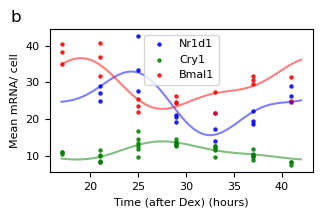

In [7]:
#%%
# Plot mean mRNA levels along with two-harmonic cosinor fit

fig = plt.figure(figsize=(19/2.54,16/2.54))

plt.subplot(3,2,1)

plt.scatter(time_slidesNr1d1, mean_slidesNr1d1, s=5, color='blue',alpha=0.8,label='Nr1d1') 
plt.scatter(time_slidesCry1, mean_slidesCry1, s=5, color='green',alpha=0.8,label='Cry1') 
plt.scatter(time_slidesBmal1, mean_slidesBmal1, s=5, color='red',alpha=0.8,label='Bmal1') 

plt.plot(x_predNr1d1,y_predNr1d1,color='blue',alpha=0.5)
plt.plot(x_predCry1,y_predCry1,color='green',alpha=0.5)
plt.plot(x_predBmal1,y_predBmal1,color='red',alpha=0.5)

legend = plt.legend(loc='upper center', shadow=False, frameon=True)

plt.xlabel('Time (after Dex) (hours)')
plt.ylabel('Mean mRNA/ cell')

axes = plt.gca()
a = axes.get_xlim()
b = axes.get_ylim()
plt.text(a[0]-0.15*(a[1]-a[0]),b[1]+0.05*(b[1]-b[0]), 'b',fontsize=12)

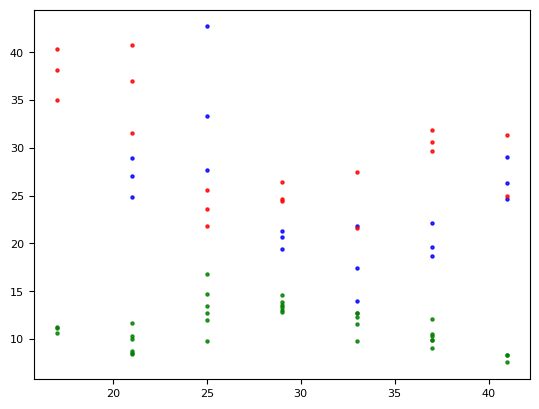

In [8]:
plt.scatter(time_slidesNr1d1, mean_slidesNr1d1, s=5, color='blue',alpha=0.8,label='Nr1d1') 
plt.scatter(time_slidesCry1, mean_slidesCry1, s=5, color='green',alpha=0.8,label='Cry1') 
plt.scatter(time_slidesBmal1, mean_slidesBmal1, s=5, color='red',alpha=0.8,label='Bmal1') 

In [22]:
idx = np.unique(np.array(time_slidesNr1d1))
len(time_slidesCry1), len(time_slidesBmal1), len(mean_slidesNr1d1)

(35, 19, 18)

In [47]:
Nr1d1_dots = pd.DataFrame({'time': np.array(time_slidesNr1d1).squeeze(), 'avg': mean_slidesNr1d1})
Nr1d1_dots

,time,avg
0,21.0,28.942857
1,21.0,27.037736
2,21.0,24.873333
3,25.0,42.704000
4,25.0,33.318519
5,25.0,27.688312
6,29.0,20.697297
7,29.0,21.248485
8,29.0,19.391813
9,33.0,21.793750


In [48]:
Cry1_dots = pd.DataFrame({'time': np.array(time_slidesCry1).squeeze(), 'avg': mean_slidesCry1})
Cry1_dots

,time,avg
0,17.0,11.224359
1,17.0,10.635220
2,17.0,11.133333
3,21.0,11.626866
4,21.0,10.037037
5,21.0,8.441558
6,21.0,8.785276
7,21.0,8.541096
8,21.0,10.342857
9,25.0,9.791667


In [49]:
Bmal1_dots = pd.DataFrame({'time': np.array(time_slidesBmal1).squeeze(), 'avg': mean_slidesBmal1})
Bmal1_dots

,time,avg
0,17.0,40.331210
1,17.0,34.973856
2,17.0,38.161290
3,21.0,36.993865
4,21.0,40.726027
5,21.0,31.607735
6,25.0,21.845638
7,25.0,25.565891
8,25.0,23.601770
9,29.0,24.419355


In [50]:
Nr1d1_dots.to_csv('Nr1d1_dots.csv')
Cry1_dots.to_csv('Cry1_dots.csv')
Bmal1_dots.to_csv('Bmal1_dots.csv')

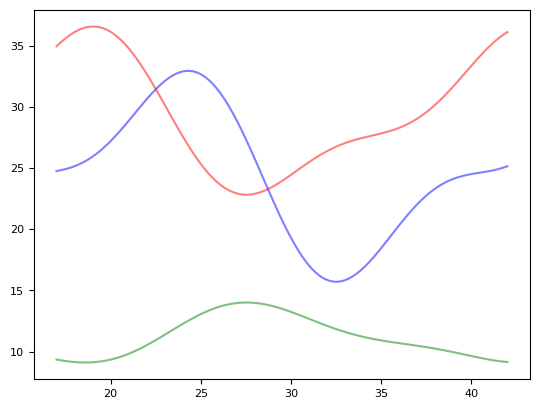

In [9]:
plt.plot(x_predNr1d1,y_predNr1d1,color='blue',alpha=0.5)
plt.plot(x_predCry1,y_predCry1,color='green',alpha=0.5)
plt.plot(x_predBmal1,y_predBmal1,color='red',alpha=0.5)

In [26]:
y_predNr1d1.shape, y_predCry1.shape, y_predBmal1.shape

((100,), (100,), (100,))

In [25]:
x_predNr1d1.shape, x_predCry1.shape, x_predBmal1.shape

((100,), (100,), (100,))

In [31]:
sum(x_predNr1d1 == x_predCry1)

100

In [32]:
mean_mRNA_cell = pd.DataFrame({'Nr1d1': y_predNr1d1,
                               'Cry1': y_predCry1,
                               'Bmal1': y_predBmal1},
                              index=x_predBmal1)
mean_mRNA_cell.head()

,Nr1d1,Cry1,Bmal1
17.000000,24.748759,9.338013,34.941828
17.252525,24.823470,9.275718,35.289297
17.505051,24.912606,9.220970,35.604568
17.757576,25.020389,9.175108,35.882650
18.010101,25.150592,9.139442,36.118870


In [33]:
mean_mRNA_cell.to_csv('mean_mRNA_cell.csv')

In [ ]:
# find phase and fold-change for each gene

phase_Nr1d1 = (x_predNr1d1[np.argmax(y_predNr1d1)]%24)*w
phase_Cry1 = (x_predCry1[np.argmax(y_predCry1)]%24)*w
phase_Bmal1 = (x_predBmal1[np.argmax(y_predBmal1)]%24)*w

fold_change_Nr1d1 = np.amax(y_predNr1d1)/np.amin(y_predNr1d1)
fold_change_Cry1 = np.amax(y_predCry1)/np.amin(y_predCry1)
fold_change_Bmal1 = np.amax(y_predBmal1)/np.amin(y_predBmal1)


ax = plt.subplot(3,3,3, projection='polar')

ax.scatter(phase_Nr1d1, fold_change_Nr1d1,label='Nr1d1',color = 'blue')
plt.annotate('Nr1d1', xy = (phase_Nr1d1+0.25,0.55*fold_change_Nr1d1))

ax.scatter(phase_Cry1, fold_change_Cry1,label='Cry1',color = 'green')
plt.annotate('Cry1', xy = (phase_Cry1+0.2,fold_change_Cry1+0.2))

ax.scatter(phase_Bmal1, fold_change_Bmal1,label='Bmal1',color = 'red')
plt.annotate('Bmal1', xy = (phase_Bmal1-0.9,fold_change_Bmal1))

ax.set_rmax(2.5)
ax.set_rticks([0, 0.5, 1, 1.5, 2])
ax.set_rlabel_position(157.5)
ax.grid(True)
xT=plt.xticks()[0]
xL=['0 h','3 h','6 h','9 h',\
    '12 h','15 h','18 h','21 h']
plt.xticks(xT, xL)
ax.set_title("Phase and fold change", va='bottom')
plt.show()

In [ ]:
#%%
# plot histograms at three different time points

xmax_Nr1d1 = 100
xmax_Cry1 = 50
xmax_Bmal1 = 100

ymaxNr1d1 = 0.065
ymaxCry1 = 0.12
ymaxBmal1 = 0.05

In [ ]:
def plot_count_hists(counts,max_x,max_y,colour,plt_num):
    pos2 = 0.45
    bins = np.arange(0,max_x)
    plt.subplot(5,3,plt_num)
    plt.hist(counts,color=colour,bins=bins,density=True)
    plt.yticks([])
    plt.xlim([0,max_x])
    plt.ylim([0,max_y])
    
    mu = np.mean(counts)
    CV = np.std(counts)/np.mean(counts)
    N = len(counts)
    axes = plt.gca()
    a = axes.get_xlim()
    b = axes.get_ylim()
    plt.text(a[1]-pos2*(a[1]-a[0]),b[1]-pos2*(b[1]-b[0]), '$\mu$ = %(mu)1.2f \nCV = %(CV)1.2f \nN = %(N)i' % {"mu":mu,"CV": CV,"N": N})    

In [ ]:
plot_count_hists(CountsNr1d1_RC[jtime_RC==21],xmax_Nr1d1,ymaxNr1d1,'blue',7)
plt.ylabel('Density')
plt.title('Nr1d1')
plt.gca().axes.xaxis.set_ticklabels([])
axes = plt.gca()
a = axes.get_xlim()
b = axes.get_ylim()
plt.text(a[0]-0.2*(a[1]-a[0]),b[1]+0.2*(b[1]-b[0]), 'b',fontsize=12)
plot_count_hists(CountsNr1d1_RC[jtime_RC==29],xmax_Nr1d1,ymaxNr1d1,'blue',10)
plt.ylabel('Density')
plt.gca().axes.xaxis.set_ticklabels([])
plot_count_hists(CountsNr1d1_RC[jtime_RC==37],xmax_Nr1d1,ymaxNr1d1,'blue',13)
plt.ylabel('Density')
plt.xlabel('mRNA/cell')

plot_count_hists(CountsCry1TOT[jtime_Cry1TOT==21],xmax_Cry1,ymaxCry1,'green',8)
plt.title('Cry1')
plt.gca().axes.xaxis.set_ticklabels([])
plot_count_hists(CountsCry1TOT[jtime_Cry1TOT==29],xmax_Cry1,ymaxCry1,'green',11)
plt.gca().axes.xaxis.set_ticklabels([])
plot_count_hists(CountsCry1TOT[jtime_Cry1TOT==37],xmax_Cry1,ymaxCry1,'green',14)
plt.xlabel('mRNA/cell')

plot_count_hists(CountsBmal1_BC[jtime_BC==21],xmax_Nr1d1,ymaxNr1d1,'red',9)
plt.title('Bmal1')
plt.gca().axes.xaxis.set_ticklabels([])
plot_count_hists(CountsBmal1_BC[jtime_BC==29],xmax_Nr1d1,ymaxNr1d1,'red',12)
plt.gca().axes.xaxis.set_ticklabels([])
plot_count_hists(CountsBmal1_BC[jtime_BC==37],xmax_Nr1d1,ymaxNr1d1,'red',15)
plt.xlabel('mRNA/cell')


plt.tight_layout()

In [ ]:
# to save cosinor fit parameters

#%%
import pickle
#

with open('FourierParams.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([Nr1d1_params, Cry1_params, Bmal1_params], f) 